In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
#%matplotlib qt   # doesn't work on my laptop
from tistools import read_inputfile, get_LMR_interfaces, read_pathensemble, get_weights
from tistools import set_tau_distrib, set_tau_first_hit_M_distrib, cross_dist_distr, pathlength_distr
from tistools import collect_tau, collect_tau1, collect_tau2, collect_taum
from tistools import ACCFLAGS, REJFLAGS

from tistools import get_lmr_masks, get_generation_mask, get_flag_mask
from tistools import unwrap_by_weight, running_avg_local_probs, get_local_probs, get_globall_probs, get_global_probz

from pprint import pprint    # to print the vars of the pathensemble object

In [2]:
%autoreload 2   # something with pip install -e .

UsageError: unrecognized arguments: # something with pip install -e .


# Reading

In [3]:
# zero_minus_one = True if lambda_-1 interface is set
# zero_minus_one = False if lambda_-1 interface is not set

# data the maze
#---------------
indir = "/Users/an/Documents/0_mfpt/repptis1/"
zero_minus_one = True
inputfile = indir + "/out.rst"
#inputfile = indir + "/retis.rst"

# new data Elias
#---------------
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/brownian-gamma5/30k-cycles/REPPTIS"
indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump1-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump2-walls/langevin-gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbump3-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdip2-walls/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/brownian/corr/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/langevin_gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/brownian/fine_intf/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/brownian/fine_intf/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosbumpmeta-walls/langevin_gamma5/fine_intf/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdipmeta-walls/brownian/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/cosdipmeta-walls/langevin_gamma5/REPPTIS"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/2D-experiments/2D-maze/Wouter-2022/repptis3"
# indir = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/PyRETIS3/toytis/sim_istar0fix"
zero_minus_one = False
inputfile = indir + "/repptis.rst"

import os
import glob
os.chdir(indir)
print(os.getcwd())


folders = glob.glob(indir + "/0[0-9][0-9]")
folders = sorted(folders)
print(folders)

/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS
['/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/000', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/001', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/002', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/003', '/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/004']


In [4]:
# !!! last lines !!!  allow to speed up this notebook
# pe.set_orders(load=False...)  -> 1st time you run the code, this will store npy files
# pe.set_orders(load=True...)  -> next time you run the code, you can read npy files

# Reading all input
#===================
interfaces, zero_left, timestep = read_inputfile(inputfile)
LMR_interfaces, LMR_strings = get_LMR_interfaces(interfaces, zero_left)
pathensembles = []
for i,fol in enumerate(folders):
    print("#"*80)
    print(fol)
    pe = read_pathensemble(fol+"/pathensemble.txt")
    pe.set_name(fol)
    pe.set_interfaces([LMR_interfaces[i], LMR_strings[i]])
    if i==0:
        pe.set_zero_minus_one(zero_minus_one)   # TODO this is never used
        pe.set_in_zero_minus(True)
    if i==1:
        pe.set_in_zero_plus(True)
    w, _ = get_weights(pe.flags, ACCFLAGS, REJFLAGS, verbose = False)
    pe.set_weights(w)
    print("pathensemble info: ")
    pprint(vars(pe))
    pathensembles.append(pe)
    # read order parameters order.txt/order.npy into path ensemble object
    #pe.set_orders(load=False, acc_only=True, save=False) # if saving doesn't work
    #### CHANGE HERE ####
    # pe.set_orders(load=False, acc_only=True, save=True) # for the 1st time
    pe.set_orders(load=True, acc_only=True) # for the next times, save=True/False is not important

################################################################################
/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/000
pathensemble info: 
{'cyclenumbers': array([    0,     1,     2, ...,  9998,  9999, 10000]),
 'flags': array(['ACC', 'ACC', 'ACC', ..., 'ACC', 'ACC', 'ACC'], dtype='<U3'),
 'generation': array(['ki', 'sh', 'sh', ..., 'sh', 'sh', 'sh'], dtype='<U2'),
 'has_zero_minus_one': False,
 'in_zero_minus': True,
 'in_zero_plus': False,
 'interfaces': [[-0.1, -0.1, -0.1], ['l_[0]', 'l_[0]', 'l_[0]']],
 'lambmaxs': array([-0.09999883, -0.09990865, -0.09987787, ..., -0.0999174 ,
       -0.09985508, -0.09995626]),
 'lambmins': array([-0.20118421, -0.27415918, -0.35706824, ..., -0.24388594,
       -0.27335122, -0.26841137]),
 'lengths': array([86018,  2921,  2209, ...,  3852,  2937,  3034]),
 'lmrs': array(['RMR', 'RMR', 'RMR', ..., 'RMR', 'RMR', 'RMR'], dtype='<U3'),
 'name': '/mnt/0bf0c339-34bb-4500-a5fb-f3c

# Analysis

In [23]:
# Setting path ensemble properties
#==================================
for i,fol in enumerate(folders):
    print(i)
    print("Calculating path lengths.")
    set_tau_distrib(pathensembles[i])
    print("Done.")

    if True:
        print("Calculating first hitting lengths to middle interface")
        set_tau_first_hit_M_distrib(pathensembles[i])
        print("Done.")

0
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
1
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
2
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
3
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.
4
Calculating path lengths.
Done.
Calculating first hitting lengths to middle interface
Done.


In [24]:
# Analyze the pptis simulation.
# Analysis output is saved to the data dictionary.
data = {}
for i, pe in enumerate(pathensembles):
    print("doing pathensemble {}".format(i))
    if i == 0:
        data[i] = {}
        continue  # TODO: make [0-] analysis ???

    # masks - TODO not used further on?
    # TODO these functions are duplicate in repptis_analysis
    #masks = get_lmr_masks(pe)
    #loadmask = get_generation_mask(pe, "ld")
    #print("Amount of loads: {}".format(np.sum(loadmask)))
    ##hardloadmask = get_hard_load_mask(loadmask)
    #accmask = get_flag_mask(pe, "ACC")

    # pathtype_cycles
    pathtypes = ("LML", "LMR", "RML", "RMR")
    pathtype_cycles = {}
    for ptype in pathtypes:
        pathtype_cycles[ptype] = unwrap_by_weight(
                (pe.lmrs == ptype).astype(int), pe.weights)
    
    # running average analysis: ["running"]
    data[i] = {}
    data[i]["running"] = {}
    data[i]["running"]["plocal"] = {}
    # you'll still have to hardload select pe.weigths... TODO. # this is comment wouter?
    for (ptype, p_loc) in zip(pathtypes, 
                              running_avg_local_probs(pathtype_cycles, 
                                                      pe.weights, tr = False)):
        data[i]["running"]["plocal"][ptype] = p_loc

    # analysis using all data: ["full"]
    plocfull = get_local_probs(pe, tr=False)
    data[i]["full"] = {}
    for ptype in pathtypes:
        data[i]["full"][ptype] = plocfull[ptype]

    # data[i] have now ["full"] and ["running"]

doing pathensemble 0
doing pathensemble 1
Weights of the different paths:
wRMR = 0
wRML = 5205
wLMR = 4795
wLML = 0
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 1.0
pLML = 0.0
Local crossing probabilities:
p2R = 0.4795
p2L = 0.5205
doing pathensemble 2
Weights of the different paths:
wRMR = 0
wRML = 5065
wLMR = 4935
wLML = 0
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 1.0
pLML = 0.0
Local crossing probabilities:
p2R = 0.4935
p2L = 0.5065
doing pathensemble 3
Weights of the different paths:
wRMR = 0
wRML = 5024
wLMR = 4976
wLML = 0
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 1.0
pLML = 0.0
Local crossing probabilities:
p2R = 0.4976
p2L = 0.5024
doing pathensemble 4
Weights of the different paths:
wRMR = 0
wRML = 5079
wLMR = 4921
wLML = 0
Local crossing probabilities:
pRMR = 0.0
pRML = 1.0
pLMR = 1.0
pLML = 0.0
Local crossing probabilities:
p2R = 0.4921
p2L = 0.5079


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools/repptis_analysis.py:555: RuntimeWarning: invalid value encountered in divide
  p_PP = cumsums['RMR']/(cumsums['RML']+cumsums['RMR'])
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/tistools/repptis_analysis.py:556: RuntimeWarning: invalid value encountered in divide
  p_PN = cumsums['RML']/(cumsums['RML']+cumsums['RMR'])


In [25]:

for i, pe in enumerate(pathensembles):
    upe = pe.unify_pe()
    # Pathlength distribution
    data[i]["pathlengths"] = pathlength_distr(upe)  # these might be used later or not! TODO
        
#=======================================
# make figures
makefigs = True 
if makefigs:
    for i, pe in enumerate(pathensembles):     
        if i == 0:
            continue
        # Cross distances distribution
        L, M, R, lmlpercs, lmllambs, rmrpercs, rmrlambs = cross_dist_distr(pe)
        fig,ax = plt.subplots()
        ax.plot(lmllambs, lmlpercs, lw=1, c="g")
        ax.plot(rmrlambs, rmrpercs, lw=1, c="r")
        for lamb in (L,M,R):
            ax.axvline(lamb, color='k', linestyle='--', lw = 0.5)
        ax.set_xlabel('Cross distance')
        ax.set_ylabel('Frequency')
        ax.set_title("Ensemble {}. L = {}, M = {}, R = {}".format(
            pe.name, L, M, R))
        ax.set_ylim(0)
        fig.savefig(f"pathensemble_{i}_crossdist.pdf")
        plt.close(fig)

        # Pathlength distribution      
        for ptype in pathtypes:
            fig, ax = plt.subplots()
            ax.plot(data[i]["pathlengths"][ptype]["bin_centers"], 
                data[i]["pathlengths"][ptype]["hist"])
            ax.set_xlabel('Pathlength')
            ax.set_ylabel('Frequency')
            ax.set_title(f"{np.sum(data[i]['pathlengths'][ptype]['hist'])} " + \
                         f"{ptype} paths. ")
            ax.legend([f"mean = {data[i]['pathlengths'][ptype]['mean']:.2f}, " + \
                          f"std = {data[i]['pathlengths'][ptype]['std']:.2f}"])
            fig.savefig(f"pathensemble_{i}_pathlength_{ptype}.pdf")
            plt.close(fig)

Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True
Are all weights 1?  True
Are all paths accepted?  True


/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/elias/anaconda3/envs/pastime/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Pcross with recursive relations

In [26]:
# Global crossing probabilities
# WITHOUT ERRORS #  
# Full data 
psfull = []
for i in range(1, len(pathensembles)):   # do not use the 0- ensemble
    psfull.append({"LMR": data[i]["full"]["LMR"], 
               "RML": data[i]["full"]["RML"], 
               "RMR": data[i]["full"]["RMR"],
               "LML": data[i]["full"]["LML"]})

Pminfull, Pplusfull, Pcrossfull = get_globall_probs(psfull)

This should be the same as the repptis_report.pdf value: 1.0
which is the case!
Here, the load immediately disappeared. For a simulation where this is
not the case, the above code should be adapted a little bit.


/tmp/ipykernel_389934/878040726.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


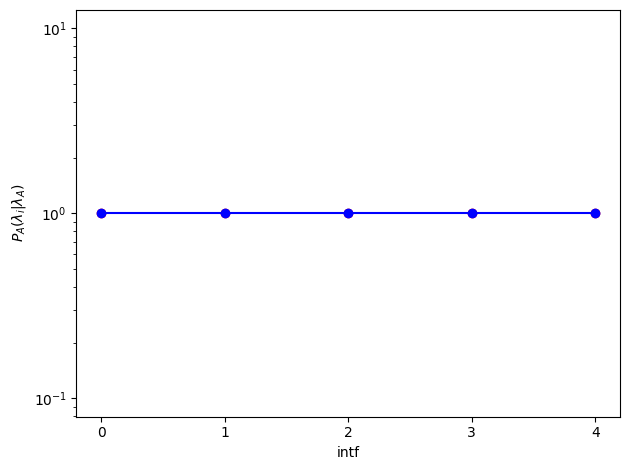

In [27]:
# Make a figure of the global crossing probabilities
fig, ax = plt.subplots()
ax.set_yscale("log")
ax.plot(Pcrossfull, "o", c = "r")
ax.errorbar([i for i in range(len(Pcrossfull))], Pcrossfull, fmt="-o", c = "b", ecolor="r", capsize=6)


# cosdip meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.004830, Pcrossfull[2]*0.05068988646, Pcrossfull[3]*0.05189862680, Pcrossfull[4]*0.05071184896, Pcrossfull[5]*0.05083284286, Pcrossfull[6]*0.05067963543], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002535, Pcrossfull[2]*0.04393065503, Pcrossfull[3]*0.04910273500, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.05789033634, Pcrossfull[6]*0.0614468], fmt="-o", c = "b", ecolor="r", capsize=6)

# cosbump meta true
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002629, Pcrossfull[2]*0.03973528878, Pcrossfull[3]*0.03900922030, Pcrossfull[4]*0.05239942040, Pcrossfull[5]*0.03734118282, Pcrossfull[6]*0.03899369101], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosdips
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.007239, Pcrossfull[2]*0.0414296, Pcrossfull[3]*0.0445266, Pcrossfull[4]*0.0483538], fmt="-o", c = "b", ecolor="r", capsize=6)

# 3 cosbumps
# ax.errorbar([i for i in range(7)], Pcrossfull, yerr=[0, 0.002295, Pcrossfull[2]*0.0328798, Pcrossfull[3]*0.031594, Pcrossfull[4]*0.031474, Pcrossfull[5]*0.03080392, Pcrossfull[6]*0.0308589], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps
#ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002768, Pcrossfull[2]*0.04440278, Pcrossfull[3]*0.043053, Pcrossfull[4]*0.0463156], fmt="-o", c = "b", ecolor="r", capsize=6)

# 2 cosbumps Langevin
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.006395, Pcrossfull[2]*0.02092401277, Pcrossfull[3]*0.01899419954, Pcrossfull[4]*0.01929952226], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat dt=0.00002 30k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.003294, Pcrossfull[2]*0.07640968, Pcrossfull[3]*0.07789262, Pcrossfull[4]*0.0812692], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat 100k cycles
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.002741, Pcrossfull[2]*0.034092, Pcrossfull[3]*0.033621, Pcrossfull[4]*0.0398], fmt="-o", c = "b", ecolor="r", capsize=6)

# flat Langevin
# ax.errorbar([i for i in range(5)], Pcrossfull, yerr=[0, 0.013684, Pcrossfull[2]*0.0825226801, Pcrossfull[3]*0.01027325454, Pcrossfull[4]*0.02130629112], fmt="-o", c = "b", ecolor="r", capsize=6)

ax.set_xlabel("intf")
ax.set_ylabel(r"$P_A(\lambda_i|\lambda_A)$")
ax.set_xticks(np.arange(len(interfaces)))
fig.tight_layout()
fig.show()
fig.savefig("Global_probs.pdf")

print("This should be the same as the repptis_report.pdf value:", Pcrossfull[-1])
print("which is the case!")
print("Here, the load immediately disappeared. For a simulation where this is")
print("not the case, the above code should be adapted a little bit.")

In [28]:
# TODO I am not sure what this is

# Construct lists of the local probs

# Or we can use the get_global_probz function, using lists of the local probs
# These do not use the 0- ensemble
pmps = [data[i]["full"]["LMR"] for i in range(1,len(pathensembles))]
pmms = [data[i]["full"]["LML"] for i in range(1,len(pathensembles))]
ppps = [data[i]["full"]["RMR"] for i in range(1,len(pathensembles))]
ppms = [data[i]["full"]["RML"] for i in range(1,len(pathensembles))]
a,b,c = get_global_probz(pmps, pmms, ppps, ppms)
print("This should be the same as the repptis_report.pdf value:", c[-1])

This should be the same as the repptis_report.pdf value: 1.0


# Now work with MSM

In [29]:
from tistools import construct_M
from tistools import global_cross_prob
from tistools import mfpt_to_first_last_state

from tistools import create_labels_states

In [30]:
def print_vector(g, states=None):
    if states is None:
        for i in range(len(g)):
            print("state", i, g[i])
    else:
        for i in range(len(g)):
            print("state", states[i], g[i][0])

In [31]:
print(interfaces)
N = len(interfaces)
# assert N >= 4
NS = 4*N-5
print("N", N)
print("len pmms", len(pmms))
print("NS", NS)

#labels2 = ["0+- LML","0+- LMR","0+- RML","1+- LML","1+- LMR",
#           "1+- RML", "1+- RMR", "2+- LML", "2+- LMR",
#           "2+- RML", "2+- RMR", "3+- LML", "3+- LMR",]
labels1, labels2 = create_labels_states(N)

[-0.1, 0.0, 0.1, 0.2, 0.3]
N 5
len pmms 4
NS 15


In [32]:
print("mm", pmms)
print("mp", pmps)
print("pm", ppms)
print("pp", ppps)
print("sum", np.array(pmms)+np.array(pmps))
print("sum", np.array(ppms)+np.array(ppps))
M = construct_M(pmms, pmps, ppms, ppps, N)

#Local crossing probabilities:
#pRMR = 0.34205627942625644.  #ppps
#pRML = 0.6579437205737436.   #ppms
#pLMR = 0.25316455696202533.  #pmps
#pLML = 0.7468354430379747.   #pmms

mm [0.0, 0.0, 0.0, 0.0]
mp [1.0, 1.0, 1.0, 1.0]
pm [1.0, 1.0, 1.0, 1.0]
pp [0.0, 0.0, 0.0, 0.0]
sum [1. 1. 1. 1.]
sum [1. 1. 1. 1.]


In [33]:
print("M")
print("shape", M.shape)
print("sum prob in rows", np.sum(M,axis=1))
print(M)
# row 8, 10, 12, 14. # counting starts from 0   not okay!!!!

M
shape (15, 15)
sum prob in rows [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


# Look at this Markov model

In [34]:
#import numpy.linalg
vals, vecs = np.linalg.eig(M)
print(vals)
vals, vecs = np.linalg.eig(M.T)
print(vals)

[ 0. +0.j         0. +0.j         0. +0.j         0. +0.j
  0. +0.j         0. +0.j         0. +0.j         0. +0.j
  0. +0.j        -1. +0.j        -0.5+0.8660254j -0.5-0.8660254j
  0.5+0.8660254j  0.5-0.8660254j  1. +0.j       ]
[-1. +0.j        -0.5+0.8660254j -0.5-0.8660254j  0.5+0.8660254j
  0.5-0.8660254j  1. +0.j         0. +0.j         0. +0.j
  0. +0.j         0. +0.j         0. +0.j         0. +0.j
  0. +0.j         0. +0.j         0. +0.j       ]


In [35]:
print("what if chain propagates")
print("A[0,:]")
# check stationary behavior
A = M
for n in range(10):
    A = np.dot(A,M)
    #print(A)
    print(A[0,:])
    print(np.sum(A[0,:]))  # is 1 indeed

what if chain propagates
A[0,:]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1.0
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
1.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
1.0


# Pcross with MSM

In [36]:
# global crossing prob
z1, z2, y1, y2 = global_cross_prob(M)
print("Z")
print_vector(z1, labels1)
print_vector(z2, labels2)
print("Y")
print_vector(y1, labels1)
print_vector(y2, labels2)
print("global crossing prob", y1[0])

Z
state 0-      0
state B       1
state 0+- LML 0.0
state 0+- LMR 1.0
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 1.0
state 1+- RML 0.0
state 1+- RMR 1.0
state 2+- LML 0.0
state 2+- LMR 1.0
state 2+- RML 0.0
state 2+- RMR 1.0
state 3+- LML 0.0
state 3+- LMR 1.0
Y
state 0-      1.0
state B       0.0
state 0+- LML 0.0
state 0+- LMR 1.0
state 0+- RML 0.0
state 1+- LML 0.0
state 1+- LMR 1.0
state 1+- RML 0.0
state 1+- RMR 1.0
state 2+- LML 0.0
state 2+- LMR 1.0
state 2+- RML 0.0
state 2+- RMR 1.0
state 3+- LML 0.0
state 3+- LMR 1.0
global crossing prob [1.]


# Collecting times

In [37]:
def print_all_tau(pathensembles, taumm, taump, taupm, taupp):
    # print all tau
    print(f"                  mm            mp            pm            pp")
    for i in range(len(pathensembles)):
        print(f"{i} {pathensembles[i].name}  {taumm[i]:13.1f} {taump[i]:13.1f} {taupm[i]:13.1f} {taupp[i]:13.1f}")

In [38]:
tau_mm, tau_mp, tau_pm, tau_pp = collect_tau(pathensembles)
tau1_mm, tau1_mp, tau1_pm, tau1_pp = collect_tau1(pathensembles)
tau2_mm, tau2_mp, tau2_pm, tau2_pp = collect_tau2(pathensembles)
taum_mm, taum_mp, taum_pm, taum_pp = collect_taum(pathensembles)

Collect tau
ensemble 0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/000
ensemble 1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/001
ensemble 2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/002
ensemble 3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/003
ensemble 4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/004
Collect tau1
Collect tau2
Collect taum


In [39]:
print("tau")
print_all_tau(pathensembles, tau_mm, tau_mp, tau_pm, tau_pp)
print("\ntau1")
print_all_tau(pathensembles, tau1_mm, tau1_mp, tau1_pm, tau1_pp)
print("\ntaum")
print_all_tau(pathensembles, taum_mm, taum_mp, taum_pm, taum_pp)
print("\ntau2")
print_all_tau(pathensembles, tau2_mm, tau2_mp, tau2_pm, tau2_pp)

tau
                  mm            mp            pm            pp
0 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/000            nan           nan           nan        2859.7
1 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/001            nan         627.8         607.2           nan
2 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/002            nan        1207.4        1206.2           nan
3 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/003            nan        1179.1        1225.6           nan
4 /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/MSM-REPPTIS/1D-experiments/HPC/flat_w-walls/newtonian/REPPTIS/004            nan        1214.7        1251.2           nan

tau1
                  mm            mp            pm            pp
0 /m

In [760]:
def construct_tau_vector(N, NS, taumm, taump, taupm, taupp):
    assert N>=3
    assert NS==4*N-5
    assert len(taumm) == N
    assert len(taump) == N
    assert len(taupm) == N
    assert len(taupp) == N
    # unravel the values into one vector
    tau = np.zeros(NS)
    # [0-]
    tau[0] = taupp[0]
    # [0+-]
    tau[1] = taumm[1]
    tau[2] = taump[1]
    tau[3] = taupm[1]
    # [1+-] etc
    for i in range(1,N-2):
        tau[4*i]   = taumm[i+1]
        tau[4*i+1] = taump[i+1]
        tau[4*i+2] = taupm[i+1]
        tau[4*i+3] = taupp[i+1]
    # [(N-2)^(-1)]
    tau[-3] = taumm[-1]
    tau[-2] = taump[-1]
    # B
    tau[-1] = 0.   # whatever
    return tau

In [761]:
tau  = construct_tau_vector(N, NS, tau_mm, tau_mp, tau_pm, tau_pp)
tau1 = construct_tau_vector(N, NS, tau1_mm, tau1_mp, tau1_pm, tau1_pp)
taum = construct_tau_vector(N, NS, taum_mm, taum_mp, taum_pm, taum_pp)
tau2 = construct_tau_vector(N, NS, tau2_mm, tau2_mp, tau2_pm, tau2_pp)
tau_m = tau-tau1-tau2  # yes, this is the same thing as taum

print("tau")
print(tau)
print("\n")
print("tau1")
print(tau1)
print("taum")
print(taum)
print("tau2")
print(tau2)

print("\n")
print("tau = tau1+taum+tau2 => difference is", np.sum((tau-tau1-taum-tau2)**2))

# Compute tau for [0+]

In [739]:
g1, g2, h1, h2 = mfpt_to_first_last_state(M, tau1, tau_m, tau2) #, doprint=True)
print("G")
print_vector(g1, labels1)
print_vector(g2, labels2)
print("H")
print_vector(h1, labels1)
print_vector(h2, labels2)
print("interesting")
print(h1[0])

G
state 0-      0.0
state B       0.0
state 0+- LML 475.9322472200672
state 0+- LMR 2780.527858657938
state 0+- RML 0.0
state 1+- LML 700.7793518682487
state 1+- LMR 3491.443165185334
state 1+- RML 151.4395075819338
state 1+- RMR 4153.437971683017
state 2+- LML 794.7747897196825
state 2+- LMR 4050.873307337215
state 2+- RML 314.35855623240343
state 2+- RMR 4500.6634362344275
state 3+- LML 994.830746630299
state 3+- LMR 4048.0750564753466
state 3+- RML 498.0054735062344
state 3+- RMR 4552.856965440902
state 4+- LML 1474.5653170780972
state 4+- LMR 3896.156405240331
state 4+- RML 873.7037073109193
state 4+- RMR 4426.950025839908
state 5+- LML 2265.7890460925437
state 5+- LMR 3767.4022370871517
state 5+- RML 1641.307532248391
state 5+- RMR 4343.988351953679
state 6+- LML 3182.750305729226
state 6+- LMR 3654.095999701859
state 6+- RML 2455.9168947471208
state 6+- RMR 4370.384087827282
state 7+- LML 3318.0764630633976
state 7+- LMR 3497.432915352966
state 7+- RML 2776.883568982561
state 7+-

In [740]:
print(h1[0][0])

[2255.52808078]


# Flux

In [741]:
flux = 1/(tau[0]+h1[0][0])
dt = 0.0002
flux
print(flux/dt, "1/time")

[0.97508598] 1/time
